In [1]:
%config Completer.use_jedi=False

In [2]:
import pandas as pd

pd.options.display.max_rows = None

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# import a single subject

in_path = '../data/Keystrokes/files/114531_keystrokes.txt'
df = pd.read_csv(in_path, sep='\t')

df.columns = [_.lower() for _ in df.columns]
df['keypress_duration_ms'] = df.release_time - df.press_time
df.head(2)

,participant_id,test_section_id,sentence,user_input,keystroke_id,press_time,release_time,letter,keycode,keypress_duration_ms
0,114531,1245408,Thanks I needed that today!,Thanks I needed that today,59219950,1473435851222,1473435851488,SHIFT,16,266
1,114531,1245408,Thanks I needed that today!,Thanks I needed that today,59219947,1473435851374,1473435851482,T,84,108


# IKI 

In [6]:
def add_iki_column(df, iki_exclude_threshold_ms = 1500):
    """Calculate IKI and return a new dataaset with relevant columns
    
    Arguments:
        df (pandas.DataFrame): Keystroke data
        
    Keywork arguments:
        iki_exclude_threshold_ms (int): Rows with an IKI greater than
            this value will be marked for exclusion
    
    Returns (pandas.DataFrame)
    
    Columns added:
        iki_ms (float): The IKI in milliseconds
        iki_exclude (str): If this string is populated, this record should
            be excluded from IKI analysis for the reason given
        iki_ms_include (float): Use this column for analysis. It is
            equal to iki_ms, but only populated when iki_exclude is
            empty            
        bigram (str): The pair of keystrokes for the given row. The
            first keystroke is from the previous row, the second key
            stroke is from this row. Examples 'th', 'BKSPa', ' s'
        
    """

    df = df.copy()

    # calculate IKI
    df['iki_ms'] = df.press_time.diff().astype('float')
    
    # identify section breaks
    df['test_section_id_diff'] = df.test_section_id.diff()
    df['new_section'] = df.test_section_id_diff != 0
    del df['test_section_id_diff']
    
    # mark IKIs for exclusion
    #   reasons: section breaks, over threshold
    df['iki_exclude'] = ''
    df.loc[df.new_section, 'iki_exclude'] = 'new section'
    df.loc[(df.iki_ms > iki_exclude_threshold_ms) & (df.iki_exclude == ''), 'iki_exclude'] = 'over threshold'
    df['iki_ms_include'] = df.iki_ms[df.iki_exclude == '']

    # bigram    
    df['letter_previous'] = df.letter.shift(1)
    df['bigram'] = df.letter_previous + df.letter
    del df['letter_previous']
    
    return df

In [7]:
prepped_df = add_iki_column(df)

In [20]:
def profile(df):
    """Print basic information based on a dataset for a single subject
    """
    print('All IKIs     : {:.0f} ms ({:.0f})'.format(
        df.iki_ms.mean(),
        df.iki_ms.std(),
        ))
    print('Included IKIs: {:.0f} ms ({:.0f})'.format(
        df.iki_ms_include.mean(),
        df.iki_ms_include.std(),
        ))
    print('\nKeystroke counts: \n', df.iki_exclude.value_counts())

    fig, axes = plt.subplots(1, 2)
    
    ax = axes[0]
    ax.hist(df.iki_ms.dropna(), bins=50);
    ax.set_title('All IKIs')
    
    ax = axes[1]
    ax.hist(df.iki_ms_include.dropna(), bins=50);
    ax.set_title('Included IKIs')

All IKIs     : 220 ms (334)
Included IKIs: 177 ms (125)

Keystroke counts: 
                   688
new section        15
over threshold      2
Name: iki_exclude, dtype: int64


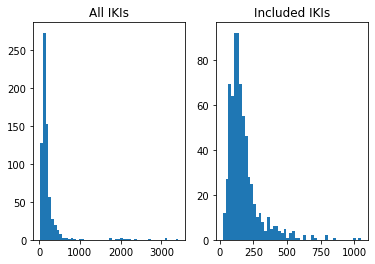

In [21]:
profile(prepped_df)

# IKI by sentence 

In [24]:
sections_df = prepped_df\
    .groupby(['test_section_id']).mean()[['iki_ms_include']].reset_index()\
    .sort_values(['iki_ms_include'], ascending=False)

In [27]:
sections_df.head()

,test_section_id,iki_ms_include
13,1245610,243.571429
5,1245494,214.714286
9,1245560,199.552632
10,1245580,195.555556
6,1245506,184.836066


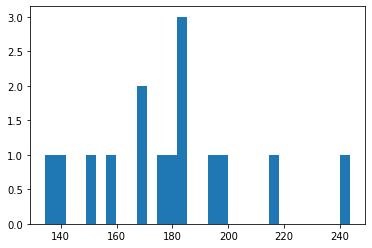

In [28]:
plt.hist(sections_df.iki_ms_include, bins=30);

# Section profile 

In [29]:
# get the ID of the slowest section
selected_section_id = sections_df.test_section_id.iloc[0]
print(selected_section_id)

1245610


In [36]:
section_df = prepped_df[prepped_df.test_section_id == selected_section_id ]

In [37]:
print('Requested input: ', section_df.sentence.iloc[0])
print('Actual input   : ', section_df.user_input.iloc[0])

Requested input:  Suite 2750 in Downtown Denver.
Actual input   :  Suite 2750 in Downtown Denver.


In [39]:
section_df[['letter', 'keypress_duration_ms', 'iki_ms', 'iki_exclude', 'keystroke_id']].head()

,letter,keypress_duration_ms,iki_ms,iki_exclude,keystroke_id
612,SHIFT,514,2221.0,new section,59229565
613,S,191,275.0,,59229557
614,U,108,227.0,,59229573
615,i,112,211.0,,59229582
616,t,237,106.0,,59229589


# IKI by bigram 

In [42]:
bigram_count_threshold = 5

bigrams_df = prepped_df\
    .groupby(['bigram']).agg({'iki_ms_include': ['mean', 'count']}).reset_index()
bigrams_df.columns = ['bigram', 'iki_ms_include_mean', 'count']
bigrams_df = bigrams_df.sort_values(['iki_ms_include_mean'])
print('Total bigrams: {}'.format(bigrams_df.shape[0]))

bigrams_common_df = bigrams_df[bigrams_df['count'] > bigram_count_threshold]
print('Fastest bigrams with atleast {} occurrences'.format(bigram_count_threshold))
bigrams_common_df.head(10)

Total bigrams: 272
Fastest bigrams with atleast 5 occurrences


,bigram,iki_ms_include_mean,count
150,ha,72.833333,6
248,th,80.363636,11
265,wi,98.833333,6
163,in,104.500000,10
151,he,105.222222,9
187,n,118.000000,12
247,te,120.666667,6
242,t,126.750000,8
234,s,128.375000,8
117,co,131.714286,7


# 1,000 participants 

In [43]:
in_path = '../data/Keystrokes/n1000.txt'

In [45]:
in_path = '../data/Keystrokes/n1000_clean.txt'

In [46]:
# import the data
df = pd.read_csv(in_path, sep='\t', encoding='latin1', quoting=3)
df.columns = [_.lower() for _ in df.columns]
df['keypress_duration_ms'] = df.release_time - df.press_time
import_n1000_df = df
del df

In [47]:
# add the prep columns and confirm expected length
n1000_df = add_iki_column(import_n1000_df)
assert n1000_df.participant_id.unique().size == 1000

In [49]:
# participant level data
participants_df = n1000_df\
    .groupby(['participant_id']).agg({'iki_ms_include': ['mean', 'std', 'count']}).reset_index()
participants_df.head()

participant_id iki_ms_include                  
                           mean         std count
0            345     128.639319   98.770574   646
1            447     281.336387  212.254374   764
2           1488     231.719247  175.731950   691
3           1622     166.284542  140.199119   731
4           2270     244.500000  205.689060   652

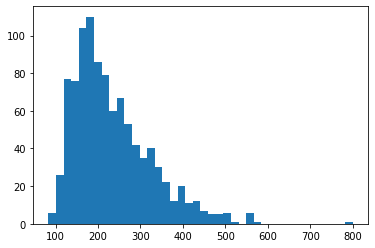

In [50]:
plt.hist(participants_df['iki_ms_include']['mean'], bins=40);

# Participant x bigram 

In [51]:
participants_bigrams_df = n1000_df\
    .groupby(['participant_id', 'bigram']).agg({'iki_ms_include': ['mean', 'std', 'count']}).reset_index()
participants_bigrams_df = participants_bigrams_df[participants_bigrams_df['iki_ms_include']['count'] > 5]

In [52]:
# Coefficient of variability 
participants_bigrams_df[('coeff_var', '')] = \
    participants_bigrams_df[('iki_ms_include', 'std')] / participants_bigrams_df[('iki_ms_include', 'mean')]

In [66]:
participants_bigrams_df.columns = [
    'participant_id',
    'bigram',
    'iki_ms_mean',
    'iki_ms_std',
    'keystroke_count',
    'coeff_var'
    ]

In [67]:
participants_bigrams_df.head()

,participant_id,bigram,iki_ms_mean,iki_ms_std,keystroke_count,coeff_var
1,345,SHIFT,177.875000,115.033458,8,0.646710
2,345,a,147.333333,105.311946,12,0.714787
3,345,b,209.166667,95.138671,6,0.454846
6,345,h,187.777778,119.471521,9,0.636239
13,345,o,134.857143,58.319318,7,0.432453


In [68]:
participants_bigrams_df.to_csv('output/participants_bigrams_2022_05_18.csv')

In [ ]:
participants_bigrams_df.to_parquet('output/participants_bigrams_2022_05_18.parquet')

In [54]:
bigrams_df = participants_bigrams_df.groupby(['bigram']).agg({
    ('iki_ms_include', 'mean'): ['mean', 'std'],
    ('iki_ms_include', 'count'): ['mean'],
    ('participant_id', ''): ['count'],
    ('coeff_var', ''): ['mean', 'std'],
    }).reset_index()
bigrams_df.columns = [
    'bigram', 
    'iki_mean', 'iki_std', 'mean_count_per_participant', 
    'participant_count',
    'coeff_var_mean', 'coeff_var_std'
    ]

In [55]:
bigrams_df.head()

,bigram,iki_mean,iki_std,mean_count_per_participant,participant_count,coeff_var_mean,coeff_var_std
0,,190.675810,42.921219,18.357143,70,0.480205,0.316534
1,CAPS_LOCK,257.270833,207.742080,7.000000,2,0.594404,0.068565
2,TAB65,299.972222,235.977246,7.500000,2,0.565670,0.372211
3,TAB69,157.950000,53.669405,9.000000,2,0.657598,0.231686
4,TAB82,171.166667,NaN,6.000000,1,0.606531,NaN


In [56]:
# filter to bigrams with at least 10 participants (have 5 occurences each minimum)
# only two-letter bigrams
common_bigrams_df = bigrams_df[
    (bigrams_df.participant_count > 10)
    &
    (bigrams_df.bigram.str.len() == 2)
    ]
common_bigrams_df = common_bigrams_df.sort_values(['iki_mean'])
print('Rows: ', common_bigrams_df.shape[0])

Rows:  97


In [57]:
common_bigrams_df.head()

,bigram,iki_mean,iki_std,mean_count_per_participant,participant_count,coeff_var_mean,coeff_var_std
376,th,125.109922,52.522885,10.728555,851,0.358288,0.252626
259,co,129.015873,51.933193,6.730769,26,0.385648,0.196535
283,fo,136.665575,52.760097,6.550000,20,0.315546,0.178674
393,wi,139.793651,66.801322,6.433333,30,0.363834,0.266390
291,ha,140.021126,77.459484,7.066667,270,0.400459,0.262981


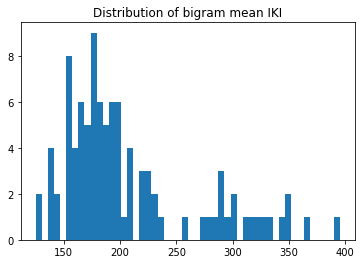

In [58]:
plt.hist(common_bigrams_df.iki_mean, bins=50);
plt.gca().set_title('Distribution of bigram mean IKI');

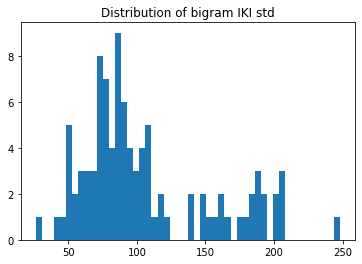

In [59]:
plt.hist(common_bigrams_df.iki_std, bins=50);
plt.gca().set_title('Distribution of bigram IKI std');

In [312]:
common_bigrams_df[common_bigrams_df.iki_std.between(175, 200)]

,bigram,iki_mean,iki_std,mean_count_per_participant,participant_count
27,t,274.046323,183.488565,14.655134,896
29,w,286.739512,187.655884,8.345038,655
30,y,288.736481,182.412465,6.648649,74
19,i,289.219373,193.354553,7.960993,564
26,s,302.172771,186.164904,7.661400,443
16,f,312.464065,177.376174,6.960674,178
18,h,316.152664,192.791132,7.422872,376
25,r,366.892740,187.368148,6.405405,37


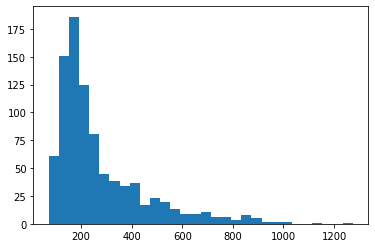

In [316]:
# bigram 'SPACE-t', distribution of IKI across participants
plt.hist(
    participants_bigrams_df.loc[participants_bigrams_df.bigram==' t', ('iki_ms_include', 'mean')]
    , bins=30);

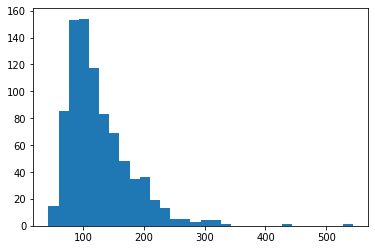

In [317]:
# bigram 'th', distribution of IKI across participants
plt.hist(
    participants_bigrams_df.loc[participants_bigrams_df.bigram=='th', ('iki_ms_include', 'mean')]
    , bins=30);

# High variability in coeff var 

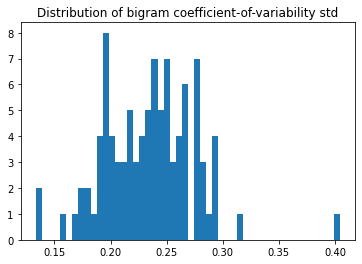

In [332]:
plt.hist(common_bigrams_df.coeff_var_std, bins=50);
plt.gca().set_title('Distribution of bigram coefficient-of-variability std');

In [333]:
common_bigrams_df[common_bigrams_df.coeff_var_std > .25]

,bigram,iki_mean,iki_std,mean_count_per_participant,participant_count,coeff_var_mean,coeff_var_std
376,th,125.109922,52.522885,10.728555,851,0.358288,0.252626
393,wi,139.793651,66.801322,6.433333,30,0.363834,0.266390
291,ha,140.021126,77.459484,7.066667,270,0.400459,0.262981
378,to,141.385188,71.806272,7.378440,436,0.413564,0.277675
292,he,142.587490,71.901089,10.232697,838,0.405727,0.252458
238,a,154.806796,61.698066,6.562500,48,0.397046,0.252149
276,er,155.298269,65.015473,8.584027,601,0.400654,0.279403
318,me,155.816168,74.364992,6.712042,191,0.422896,0.265681
353,re,161.068428,72.327264,8.640867,646,0.415739,0.284796
341,ou,161.587030,91.116127,8.184116,554,0.345643,0.253726
